In [1271]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as spicystats
import sys
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, roc_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from statsmodels.stats.proportion import proportions_ztest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score, log_loss
from tabulate import tabulate


sys.path.insert(0, '../src')
sys.path.insert(0, '../data')

import chess

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1272]:
# Read in chess dataset and sample it. Drop columns containing immaterial data.
chess_games = pd.read_csv("../data/games.csv")
chess_games.drop(['rated', 'id', 'created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id', 'opening_eco'], axis=1, inplace=True)
chess_games.sample(10)  

,turns,victory_status,winner,white_rating,black_rating,moves,opening_name,opening_ply
16812,30,resign,black,1408,1498,e4 Nc6 b3 Nf6 d3 g6 Bb2 Bg7 Nd2 O-O Nc4 e6 Nf3...,Nimzowitsch Defense,2
17333,38,mate,black,1731,1875,e4 e6 d4 b6 Nf3 Bb7 Nc3 Bb4 Bd3 Bxc3+ bxc3 Nf6...,French Defense: Normal Variation,3
4320,46,mate,black,1555,1844,d4 e5 e4 exd4 Nf3 Nc6 Nxd4 Ne5 f3 Bc5 Nf5 d5 N...,Scotch Game,7
310,102,resign,black,1605,1500,f4 Nc6 Nf3 d5 e3 Nf6 b3 Bf5 Bb2 e6 Bb5 a6 Bxc6...,Bird Opening,1
10465,73,mate,white,1550,1500,c4 e5 Nc3 Nc6 e4 Nf6 Nf3 d6 Nd5 Nxd5 cxd5 Nb4 ...,English Opening: Four Knights System | Nimzow...,7
10955,46,resign,black,1509,1540,e4 e5 Nf3 Nc6 Bb5 d6 Nc3 Bd7 d3 a6 Bc4 h6 a3 N...,Ruy Lopez: Steinitz Defense,6
8851,39,mate,white,1441,1464,e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Nf6 Nxc6 bxc6 Bg5 B...,Scotch Game: Schmidt Variation,8
13127,169,mate,white,1868,1868,e4 d6 Nf3 Nd7 d4 e5 d5 Ngf6 Nc3 b6 Bg5 Be7 Nh4...,Philidor Defense: Hanham Variation,6
5677,71,resign,black,1681,1796,e4 e6 e5 d5 d4 c5 c3 Bd7 f4 Nc6 g3 cxd4 cxd4 Q...,French Defense: Advance Variation #2,7
14050,54,resign,black,1596,1466,c4 Nf6 Nc3 g6 e3 Bg7 d4 O-O g3 c6 Bg2 d5 c5 b6...,English Opening: Anglo-Indian Defense | Queen...,3


In [1273]:
# Analyze breakdown of game outcomes, which are, mate, resign, draw, and out of time.
def chess_outcome_breakdown(chess_df):
    victory_status = chess_df['victory_status'].value_counts()
    return victory_status
chess_outcome_breakdown(chess_games)

resign       11147
mate          6325
outoftime     1680
draw           906
Name: victory_status, dtype: int64

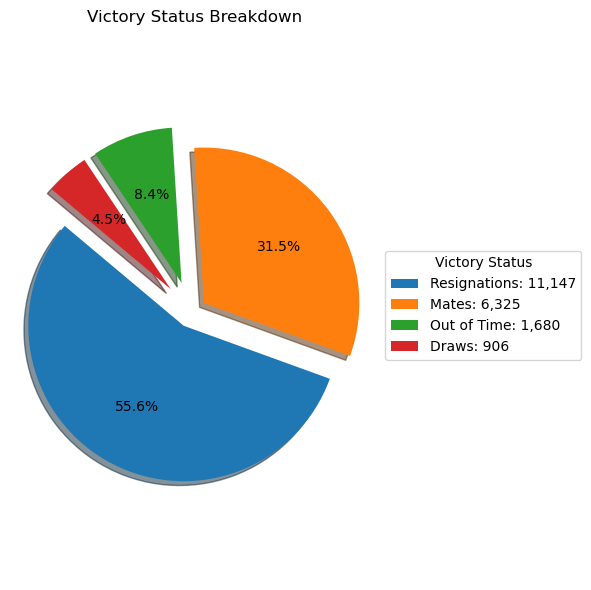

In [1274]:
# Grab and count the chess victory status, broken down by category. Make pie chart to depict the delineations.

def chess_victories(chess_df, path='../images/chess_outcomes_breakdown.png'):
     victory_status = chess_df['victory_status'].value_counts()

     fig, ax = plt.subplots(figsize = (6,6))

     sizes = victory_status.values
     labels = ['Resignations: 11,147', 'Mates: 6,325', 'Out of Time: 1,680', 'Draws: 906']
     explode = (0.1, 0.1, 0.2, 0.2)
     c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
     plt.pie(sizes, explode=explode, colors=c, 
        autopct='%1.1f%%', shadow=True, startangle=140)
     ax.legend( labels, title="Victory Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
     ax.set_title("Victory Status Breakdown")
     plt.tight_layout()
     plt.axis('equal')
     plt.savefig(path)
     return victory_status
victories_breakdown = chess_victories(chess_games)



('95.48309901286271', '4.516900987137302')

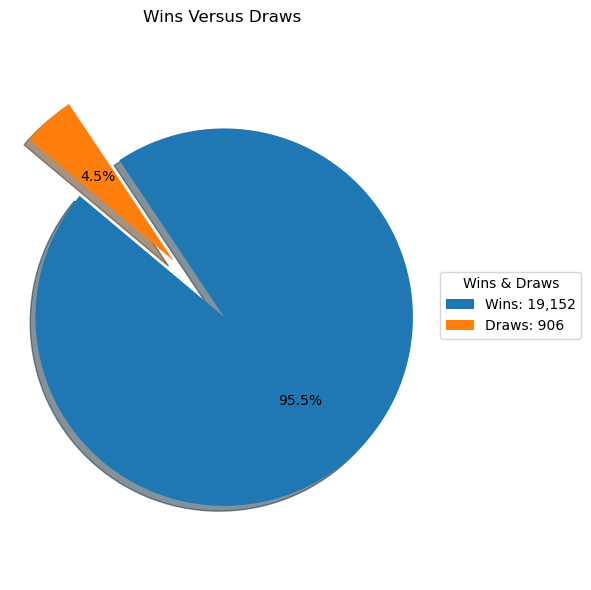

In [1275]:
# Look at games won, by mate, out of time, and resignation, and compare to draws. Make pie charts for both delineations. 

def wins_versus_draws(chess_df, path='../images/wins_versus_draws.png'):
    game_status = chess_games['victory_status'].value_counts('draw')
    game_status_percent = game_status * 100
    victories_percent = str(sum(game_status_percent.iloc[:3]))
    draws_percent = str(sum(game_status_percent.iloc[-1:]))
   
    
    fig, ax = plt.subplots(figsize = (6,6))

    sizes = victories_percent, draws_percent
    labels = ['Wins: 19,152', 'Draws: 906']
    explode = (0.2, 0.2)
    c = ['#1f77b4', '#ff7f0e']
    plt.pie(sizes, explode=explode, colors=c, 
        autopct='%1.1f%%', shadow=True, startangle=140)
    ax.legend(labels, title="Wins & Draws",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title("Wins Versus Draws")
    plt.tight_layout()
    plt.axis('equal')
    plt.savefig(path)
    return victories_percent, draws_percent
wins_versus_draws(chess_games)

In [1276]:
# Null Hypothesis 1: The average rating differential between black and white has no significance on which player wins the game.
# Alternative Hypothesis 1: The average rating differential between black and white has a significance on which player wins the game.

In [1277]:
# Null Hypothesis 2: The average number of consecutive moves where a player follows an optimal book opening has no significance on which player wins the game.
# Alternative Hypothesis 2: The average number of consecutive moves where a player follows an optimal book opening has a significance on which player wins the game.

In [1278]:
# Null Hypothesis 3: The average number of turns in a game has no significance on which player wins the game.
# Alternative Hypothesis 3: The average number of turns in a game has significance on which player wins the game.

In [1325]:
# Look at stronger white players, greater than 100 ELO difference, and map wins to 1 and draws or losses to 0.
# Perform two-sample independent t-tests to analyze the p-value and ultimately the null & alternative hypotheses for white rating differentials, 
# number of consecutive moves where a player follows an optimal book, and number of turns in the game. Generate table of results.
# Histogram plot displaying white wins versus white draws and losses when white is the superior opponent.

def chess_differentials_white(chess_df, path1='../images/white_t_tests.png', path2='../images/white_wins_vs_draws_&_losses.png'):
    chess_df = chess_df.copy()
    chess_df['Rating Differential White'] = (chess_df['white_rating'] - chess_df['black_rating']).astype(int)
    black_wins = chess_df[(chess_df['Rating Differential White'] > 100) & (chess_df['winner'] == 'black')].value_counts()
    white_greater_100 = chess_df[(chess_df['Rating Differential White'] > 100)]
    
    def victory_status(s):
        if s == 'black' or s == 'draw' :
            return 0

        else:
            return 1
    
    white_greater_100['winner'] = white_greater_100['winner'].apply(victory_status).astype(int)
    

    # white_average_rating_diff = np.mean(white_greater_100['Rating Differential White'])

    # greater_avg_rating_diff = white_greater_100['winner'][white_greater_100['Rating Differential White']>= white_average_rating_diff]

    # less_avg_rating_diff = white_greater_100['winner'][white_greater_100['Rating Differential White']< white_average_rating_diff]

    # white_ttest_rating_diff = spicystats.ttest_ind(greater_avg_rating_diff, less_avg_rating_diff, equal_var=False)

    
    # white_average_plays = np.mean(white_greater_100['opening_ply'])

    # greater_avg_plys = white_greater_100['winner'][white_greater_100['opening_ply']>= white_average_plays]
    
    # less_avg_plys = white_greater_100['winner'][white_greater_100['opening_ply']< white_average_plays]
    
    # white_ttest_opening_play = spicystats.ttest_ind(greater_avg_plys, less_avg_plys, equal_var=False)
    

    # white_average_turns = np.mean(white_greater_100['turns'])

    # greater_avg_turns = white_greater_100['winner'][white_greater_100['turns']>= white_average_turns]

    # less_avg_turns = white_greater_100['winner'][white_greater_100['turns']< white_average_turns]

    # white_ttest_num_turns = spicystats.ttest_ind(greater_avg_turns, less_avg_turns, equal_var = False)
    

    # tests = [white_ttest_rating_diff, white_ttest_opening_play, white_ttest_num_turns]
    # rows = ['White t-test: Average Rating Differential', 'White t-test: Average Opening Play', 'White t-test: Average # Turns']
    # columns = ['t-statistic', 'p-value']
    # print({'White t-test: Average Rating Differential': white_ttest_rating_diff, 'White t-test: Average Opening Play': white_ttest_opening_play, 'White t-test: Average # Turns': white_ttest_num_turns})
    
    # fig, ax = plt.subplots()
    # ax.set_axis_off()
    # ax.set_title('White t-tests Breakdown')
    # table = ax.table(
    # cellText = tests, 
    # rowLabels = rows, 
    # colLabels = columns,
    # rowColours =["palegreen"] * 10, 
    # colColours =["palegreen"] * 10,
    # cellLoc ='center', 
    # loc ='upper left')

    # fig.tight_layout()

    

    # plt.savefig(path1)
    # plt.show()
    # plt.clf()

    
    
    # fig,ax = plt.subplots()

    white_victory = white_greater_100[white_greater_100['winner'] == 1]

    counted_white_victories = white_victory['winner'].value_counts()

    white_draw_or_loss = white_greater_100[white_greater_100['winner'] == 0]

    white_draw_or_loss_count = white_draw_or_loss['winner'].value_counts()

    white_win_percentage = (counted_white_victories.values /(counted_white_victories.values + white_draw_or_loss_count.values))*100

    white_draw_or_loss_percentage = (white_draw_or_loss_count.values /(counted_white_victories.values + white_draw_or_loss_count.values))*100

    # ax.hist(white_victory['winner'], color = 'b', alpha = 0.5, label = 'White Wins: 4,110 [72.54%]')
    # ax.hist(white_draw_or_loss['winner'], color = 'g', alpha = 0.5, label = 'White Draws or Loses: 1,556 [27.46%]')
    # ax.set_title('White Draws + Losses Versus Wins', fontsize = 16)
    # ax.set_ylabel('# of Draws + Losses & Wins', fontsize = 16)
    # fig.canvas.draw()
    # labels = [item.get_text() for item in ax.get_xticklabels()]
    # labels[1] = ''
    # labels[2] = ''
    # labels[4] = ''
    # labels[5] = ''
    # labels[6] = ''
    # labels[8] = ''
    # labels[9] = ''
    # labels[3] = 'Draws + Losses'
    # labels[7] = 'Wins'
    # ax.set_xticklabels(labels)
    # ax.set_xlabel('Draws + Losses & Wins: Total Games [5,666]', fontsize = 16)
    # plt.savefig(path2)
    # ax.legend(fontsize = 10)
    
    
    return white_greater_100

chess_outcomes_white = chess_differentials_white(chess_games)
chess_outcomes_white

# The p-value for average rating differential and average opening play is less than 0.05, so we reject all the null hypotheses and there is significant difference, or impact, 
# between the white rating differentials and the number of turns in the game, all in relation to white winning the game.
# The p-value for average number of consecutive moves where white follows an optimal book opening is greater than 0.05, so we can accept the null hypothesis 
# and state that there is no significance in following an average amount of consecutive moves of an optimal book opening and white winning the game.
# Additionally, the relatively high t-statistic of approximately 11.55 and -7.47 for rating differentials and number of turns simply indicates the confidence in the predictor coefficient, 
# since they're both far greater than 1 standard deviation away, or an absolute value of 1.96, for an alpha value of 0.05, and further supports the decision to reject the null hypothesis.  
# The low t-statistic of -0.31 for opening play shows a lack of confidence in the predictor coefficient and further supports the decision to accept the null hypothesis since it's 
# less than 1 standard deviation away, or an absolute value of 1.96, for an alpha value of 0.05.
# The positive t-statistic indicates that the sample mean for rating differentials greater than or equal to the average have a large sample size 
# than the sample mean for rating differentials less than the average.
# The negative t-statistic indicates that the sample means for opening plays and number of turns greater than or equal to the average have a smaller sample size
# than the sample means for opening plays and number of turns less than the average.
# The fact that white moves first might overcome the necessity to follow an optimal book opening for a consecutive amount of moves in order to win.
# When only considering wins and draws plus losses of a higher-ranked white opponent, white wins 72.54% of the time and draws or loses 27.46% of the time over 5,666 games.

,turns,victory_status,winner,white_rating,black_rating,moves,opening_name,opening_ply,Rating Differential White
0,13,outoftime,1,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,Slav Defense: Exchange Variation,5,309
5,5,draw,0,1250,1002,e4 c5 Nf3 Qa5 a3,Sicilian Defense: Mongoose Variation,4,248
9,119,mate,1,1381,1209,e4 d5 exd5 Qxd5 Nc3 Qe5+ Be2 Na6 d4 Qf5 Bxa6 b...,Scandinavian Defense: Mieses-Kotroc Variation,4,172
10,39,mate,1,1381,1272,e3 e6 d4 d6 Bd3 c6 Nf3 Be7 Nc3 Nf6 Bd2 Bd7 Qe2...,Van't Kruijs Opening,1,109
19,25,resign,1,1500,1094,d4 d5 h3 Nc6 Nf3 Nf6 Bg5 h6 Bxf6 exf6 e3 Bb4+ ...,Queen's Pawn Game,2,406
...,...,...,...,...,...,...,...,...,...
20042,53,resign,1,1759,1265,e4 d6 d4 Nf6 Nc3 Nbd7 f4 e5 Nf3 Be7 dxe5 dxe5 ...,Lion Defense: Anti-Philidor | Lion's Cave,8,494
20044,37,mate,1,1523,1256,e4 e6 d4 d5 e5 Nc6 Nf3 f6 Bb5 Bd7 O-O Nge7 exf...,French Defense: Advance Variation #3,5,267
20050,9,outoftime,1,1243,1142,c4 e5 d4 exd4 Qxd4 Nf6 Bg5 Be7 e4,English Opening: King's English Variation,2,101
20053,24,resign,1,1691,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,Dutch Defense,2,471


In [1317]:
# Look at stronger black players, greater than 100 ELO difference, and map black wins to 1 and black draws or losses to 0.
# Perform two-sample independent t-tests to analyze the p-values and ultimately the null & alternative hypotheses for black rating differentials, 
# number of consecutive moves where a player follows an optimal book and number of turns in the game. Generate table of results.
# Histogram plot displaying black wins versus black draws and losses when black is the superior opponent.

def chess_differentials_black(chess_df, path1='../images/black_t_tests.png', path2='../images/black_wins_vs_draws_&_losses.png'):
    chess_df = chess_df.copy()
    chess_df['Rating Differential Black'] = (chess_df['black_rating'] - chess_df['white_rating']).astype(int)
    white_wins = chess_df[(chess_df['Rating Differential Black'] > 100) & (chess_df['winner'] == 'white')].value_counts()
    black_greater_100 = chess_df[(chess_df['Rating Differential Black'] > 100)]
    def victory_status(s):
        if s == 'white' or s == 'draw' :
            return 0

        else:
            return 1
    
    black_greater_100['winner'] = black_greater_100['winner'].apply(victory_status).astype(int)

    # black_average_rating_diff = np.mean(black_greater_100['Rating Differential Black'])

    # greater_avg_rating_diff = black_greater_100['winner'][black_greater_100['Rating Differential Black']>= black_average_rating_diff]

    # less_avg_rating_diff = black_greater_100['winner'][black_greater_100['Rating Differential Black']< black_average_rating_diff]

    # black_ttest_rating_diff = spicystats.ttest_ind(greater_avg_rating_diff, less_avg_rating_diff, equal_var=False)

    
    # black_average_plays = np.mean(black_greater_100['opening_ply'])

    # greater_avg_plys = black_greater_100['winner'][black_greater_100['opening_ply']>= black_average_plays]
    
    # less_avg_plys = black_greater_100['winner'][black_greater_100['opening_ply']< black_average_plays]
    
    # black_ttest_opening_play = spicystats.ttest_ind(greater_avg_plys, less_avg_plys, equal_var=False)
    

    # black_average_turns = np.mean(black_greater_100['turns'])

    # greater_avg_turns = black_greater_100['winner'][black_greater_100['turns']>= black_average_turns]

    # less_avg_turns = black_greater_100['winner'][black_greater_100['turns']< black_average_turns]

    # black_ttest_num_turns = spicystats.ttest_ind(greater_avg_turns, less_avg_turns, equal_var = False)


    # tests = [black_ttest_rating_diff, black_ttest_opening_play, black_ttest_num_turns]
    # rows = ['Black t-test: Average Rating Differential', 'Black t-test: Average Opening Play', 'Black t-test: Average # Turns']
    # columns = ['t-statistic', 'p-value']
    # print({'Black t-test: Average Rating Differential': black_ttest_rating_diff, 'Black t-test: Average Opening Play': black_ttest_opening_play, 'Black t-test: Average # Turns': black_ttest_num_turns})
    
    # fig, ax = plt.subplots()
    # ax.set_axis_off()
    # ax.set_title('Black t-tests Breakdown')
    # table = ax.table(
    # cellText = tests, 
    # rowLabels = rows, 
    # colLabels = columns,
    # rowColours =["palegreen"] * 10, 
    # colColours =["palegreen"] * 10,
    # cellLoc ='center', 
    # loc ='upper left')

    # fig.tight_layout()

    

    # plt.savefig(path1)
    # plt.show()
    # plt.clf()

    # fig,ax = plt.subplots()
    
    black_victory = black_greater_100[black_greater_100['winner'] == 1]

    counted_black_victories = black_victory['winner'].value_counts()

    black_draw_or_loss = black_greater_100[black_greater_100['winner'] == 0]

    black_draw_or_loss_count = black_draw_or_loss['winner'].value_counts()

    black_win_percentage = (counted_black_victories.values /(counted_black_victories.values + black_draw_or_loss_count.values))*100

    black_draw_or_loss_percentage = (black_draw_or_loss_count.values /(counted_black_victories.values + black_draw_or_loss_count.values))*100

    # ax.hist(black_victory['winner'], color = 'b', alpha = 0.5, label = 'Black Wins: 3,623 [69.27%]')
    # ax.hist(black_draw_or_loss['winner'], color = 'g', alpha = 0.5, label = 'Black Draws or Loses: 1,607 [30.73%]')
    # ax.set_title('Black Draws + Losses Versus Wins', fontsize = 16)
    # ax.set_ylabel('# of Draws + Losses & Wins', fontsize = 16)
    # fig.canvas.draw()
    # labels = [item.get_text() for item in ax.get_xticklabels()]
    # labels[1] = ''
    # labels[2] = ''
    # labels[4] = ''
    # labels[5] = ''
    # labels[6] = ''
    # labels[8] = ''
    # labels[9] = ''
    # labels[3] = 'Draws + Losses'
    # labels[7] = 'Wins'
    # ax.set_xticklabels(labels)
    # ax.set_xlabel('Draws + Losses & Wins: Total Games [5,230]', fontsize = 16)
    # plt.savefig(path2)
    # ax.legend(fontsize = 10)
   
    return black_win_percentage, black_draw_or_loss_percentage
   

chess_outcomes_black = chess_differentials_black(chess_games)
chess_outcomes_black

# The p-value for rating differential, number of turns, and opening play is less than 0.05, so we reject all the null hypotheses and there is significant difference, or impact, 
# between: the black rating differentials, the consecutive moves used from an optimal book opening, the number of turns in the game, all in relation to who wins the game.
# Additionally, the relatively high t-statistic of approximately 13.15, -3.52, and -3.27 for rating differentials, opening book play, and number of turns simply indicates the confidence in the predictor coefficient, 
# since they're all far greater than 1 standard deviation away, or an absolute value of 1.96, for an alpha value of 0.05, and further supports the decision to reject the null hypothesis.
# The positive t-statistic indicates that the sample mean for rating differentials greater than or equal to the average have a large sample size 
# than the sample mean for rating differentials less than the average.
# The negative t-statistic indicates that the sample means for opening plays and number of turns greater than or equal to the average have a smaller sample size
# than the sample means for opening plays and number of turns less than the average.
# When only considering wins and draws plus losses of a higher-ranked black opponent, black wins 69.27% of the time and draws or loses 30.73% of the time over 5,230 games.

(array([69.27342256]), array([30.72657744]))

{'White t-test: Average Rating Differential': Ttest_indResult(statistic=11.54604684279397, pvalue=1.8715300900887113e-30), 'White t-test: Average Opening Play': Ttest_indResult(statistic=-0.3147025978772499, pvalue=0.752999295709658), 'White t-test: Average # Turns': Ttest_indResult(statistic=-7.471706073229382, pvalue=9.230399594381829e-14)}


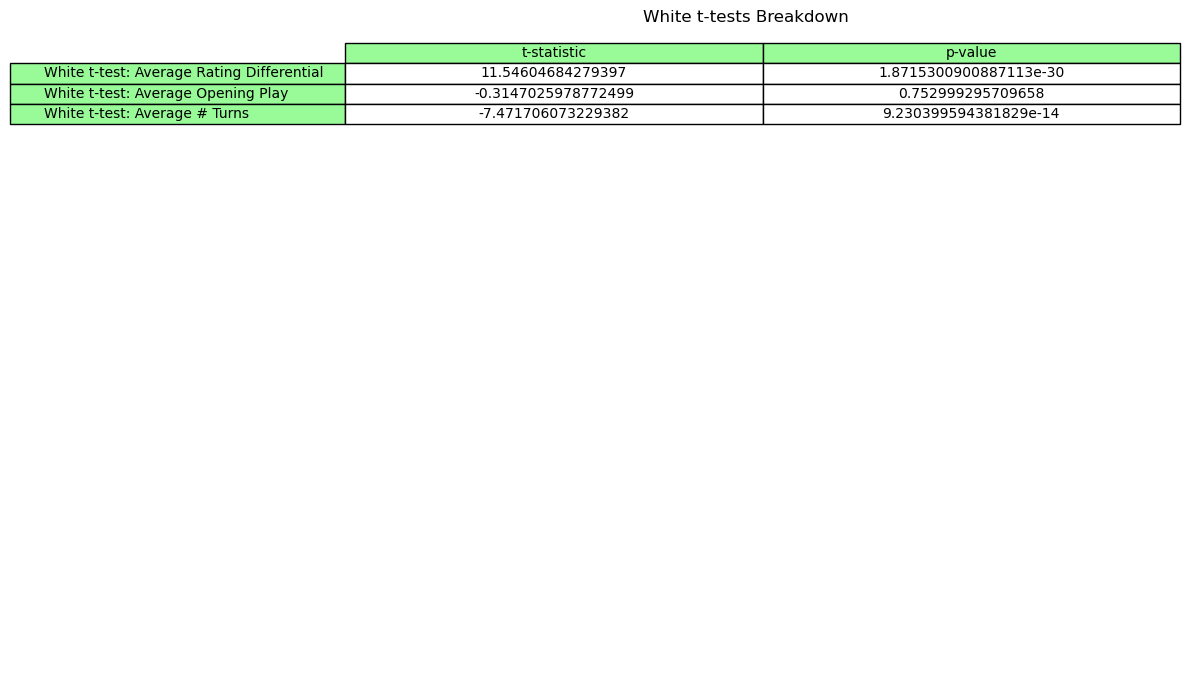

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\3301523874.py:97: UserWarning:

FixedFormatter should only be used together with FixedLocator



{'White Win Pct': 72.53794564066361, 'White Draw or Loss Pct': 27.462054359336392}
{'Black t-test: Average Rating Differential': Ttest_indResult(statistic=13.149612235367156, pvalue=8.257157993795913e-39), 'Black t-test: Average Opening Play': Ttest_indResult(statistic=-3.515890332388768, pvalue=0.00044230991158516336), 'Black t-test: Average # Turns': Ttest_indResult(statistic=-3.2708390515509955, pvalue=0.0010799562297505434)}


<Figure size 1200x700 with 0 Axes>

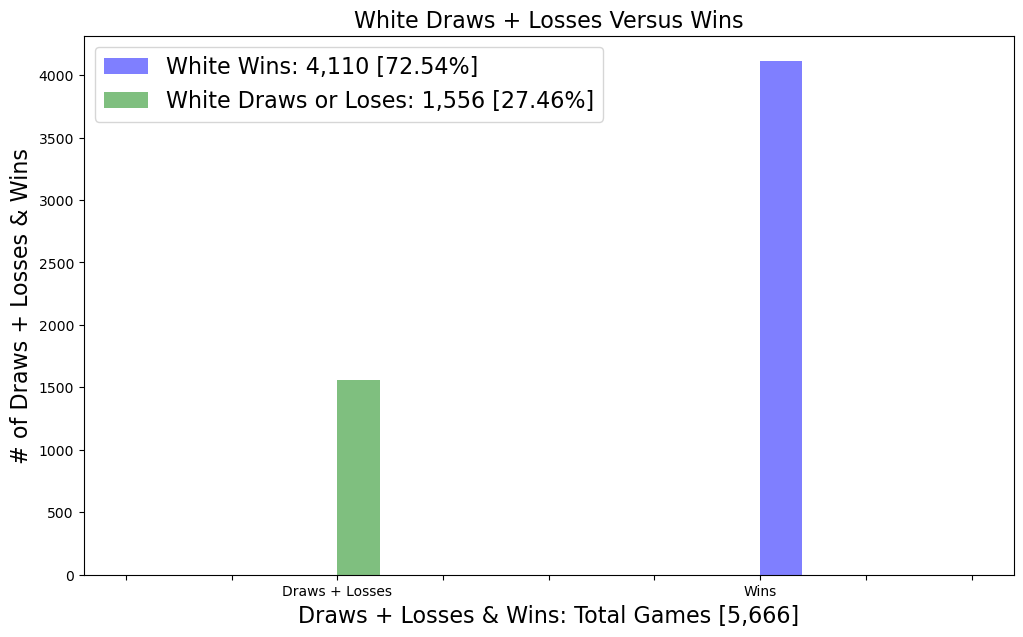

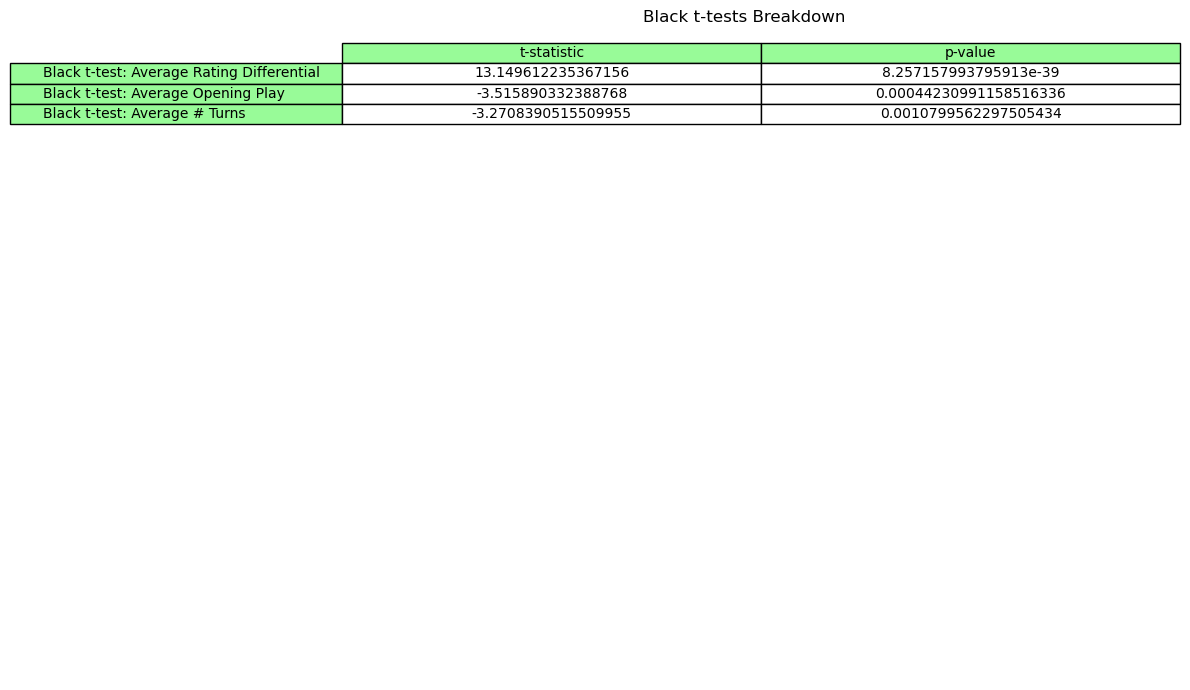

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\3112410417.py:93: UserWarning:

FixedFormatter should only be used together with FixedLocator



{'White Win Pct': 69.27342256214149, 'White Draw or Loss Pct': 30.72657743785851}


{'Pearson White Correlation': 0.1668308149961318,
 'Pearson Black Correlation': 0.17783838499201052,
 'Spearman White Correlation': 0.17851593325759896,
 'Spearman Black Correlation': 0.1902427550086633}

<Figure size 1200x700 with 0 Axes>

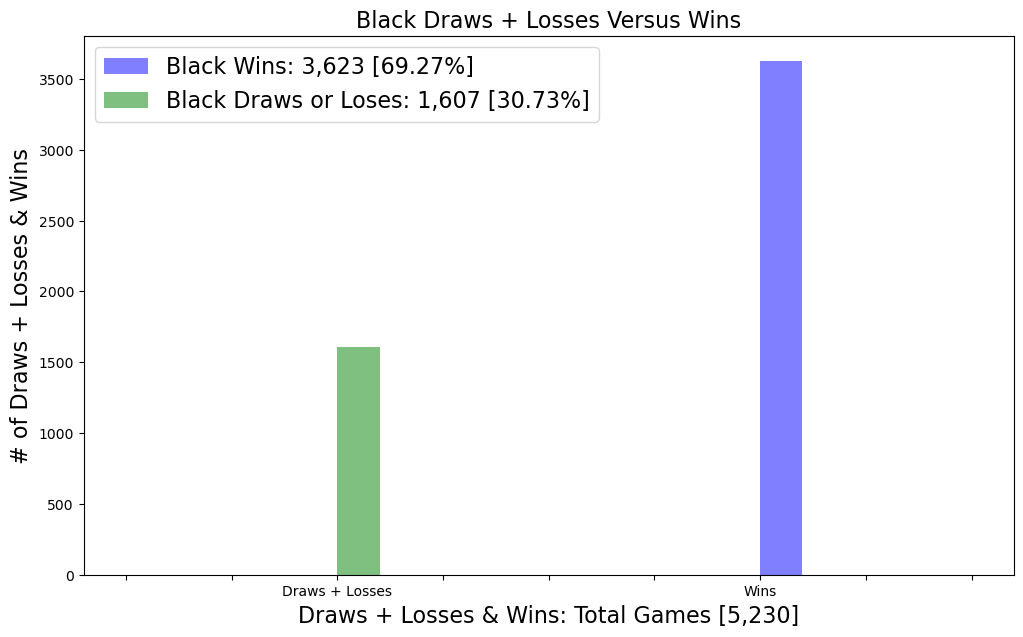

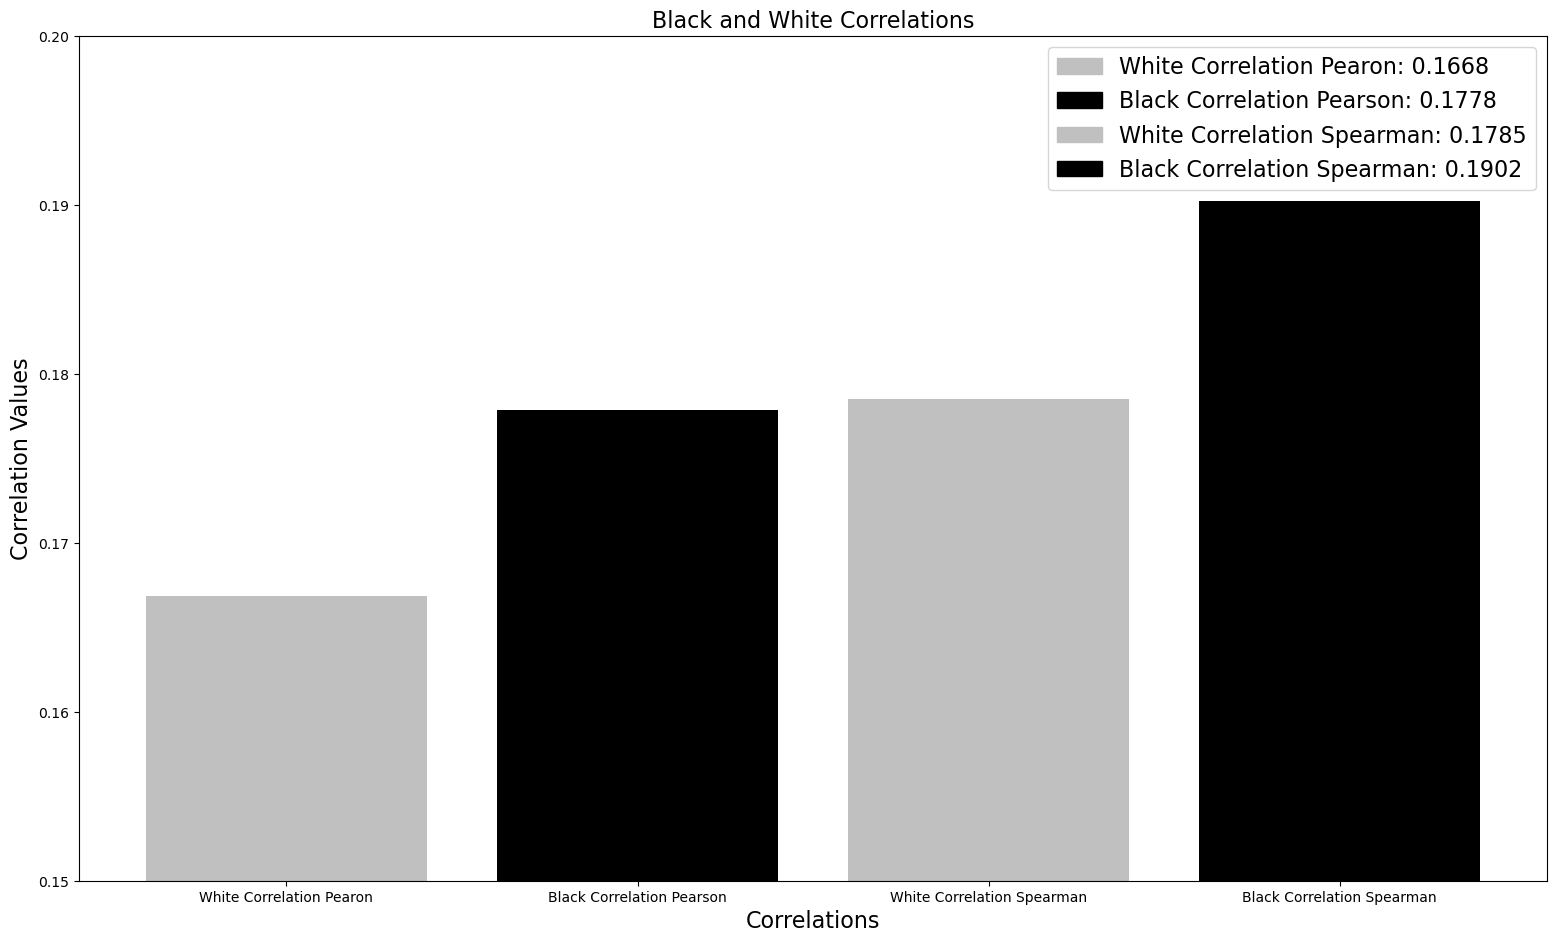

In [1281]:
# Perform linear, Pearson correlations and nonlinear, Spearman correlation to see potential correlations between rating differentals, for white and black respectively, and their victory status.
def chess_correlations(white, black, path="../images/correlations.png"):
    white = white.copy()
    black = black.copy()
    white_correlation_spearman = white['Rating Differential White'].corr(white['winner'], method ='spearman')

    black_correlation_spearman = black['Rating Differential Black'].corr(black['winner'], method ='spearman')

    white_correlation_pearson = white['Rating Differential White'].corr(white['winner'], method ='pearson')

    black_correlation_pearson = black['Rating Differential Black'].corr(black['winner'], method ='pearson')
    
    fig,ax = plt.subplots()
    x_axis = [white_correlation_pearson, black_correlation_pearson, white_correlation_spearman, black_correlation_spearman]
    x_axis_names = ['White Correlation Pearon', 'Black Correlation Pearson', 'White Correlation Spearman', 'Black Correlation Spearman']
    c = ['silver', 'black', 'silver', 'black']
    
    ax.set_ylim(0.15, 0.20)
    plt.bar(x_axis_names, x_axis, color=c)
    ax.set_title('Black and White Correlations', fontsize = 16)
    ax.set_ylabel('Correlation Values', fontsize = 16)
    ax.set_xlabel('Correlations', fontsize = 16)
    plt.tight_layout()
    fig.set_size_inches(16, 10)
    plt.savefig(path)
    white_pearson_legend = mpatches.Patch(color= 'silver', label='White Correlation Pearon: 0.1668')
    black_pearson_legend = mpatches.Patch(color= 'black', label='Black Correlation Pearson: 0.1778')
    white_spearman_legend = mpatches.Patch(color= 'silver', label='White Correlation Spearman: 0.1785')
    black_spearman_legend = mpatches.Patch(color= 'black', label='Black Correlation Spearman: 0.1902')
    plt.legend(handles=[white_pearson_legend, black_pearson_legend, white_spearman_legend, black_spearman_legend], fontsize = 16)
    
   

    return { 'Pearson White Correlation': white_correlation_pearson, 'Pearson Black Correlation': black_correlation_pearson, 'Spearman White Correlation': white_correlation_spearman, 'Spearman Black Correlation': black_correlation_spearman}
all_chess_correlations = chess_correlations(chess_differentials_white(chess_games), chess_differentials_black(chess_games))
all_chess_correlations

# There is no true correlation between white or black being a significantly stronger opponent, in terms of ELO rating, 
# and winning games versus losing or drawing games, as seen from the linear, Pearson correlations and the nonlinear, Spearman correlations below.
# Intuitively, one would think that over a continuous span of gradually increasing ELO differentials, there would be a correlation to the majority, binary class of 1, which is wins.
# Despite all of the players having respectable ratings at the very least, this counterintuition could be due to players still being considerably lower rated than grandmasters 
# which leads to miscalculations and outright blunders, despite being the higher-rated player. 

Optimization terminated successfully.
         Current function value: 0.570560
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 4532
Model:                          Logit   Df Residuals:                     4529
Method:                           MLE   Df Model:                            2
Date:                Fri, 10 Feb 2023   Pseudo R-squ.:                 0.02948
Time:                        05:49:07   Log-Likelihood:                -2585.8
converged:                       True   LL-Null:                       -2664.3
Covariance Type:            nonrobust   LLR p-value:                 7.765e-35
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
turns                        -0.0037      0.001     -4.453      0.000      -0.

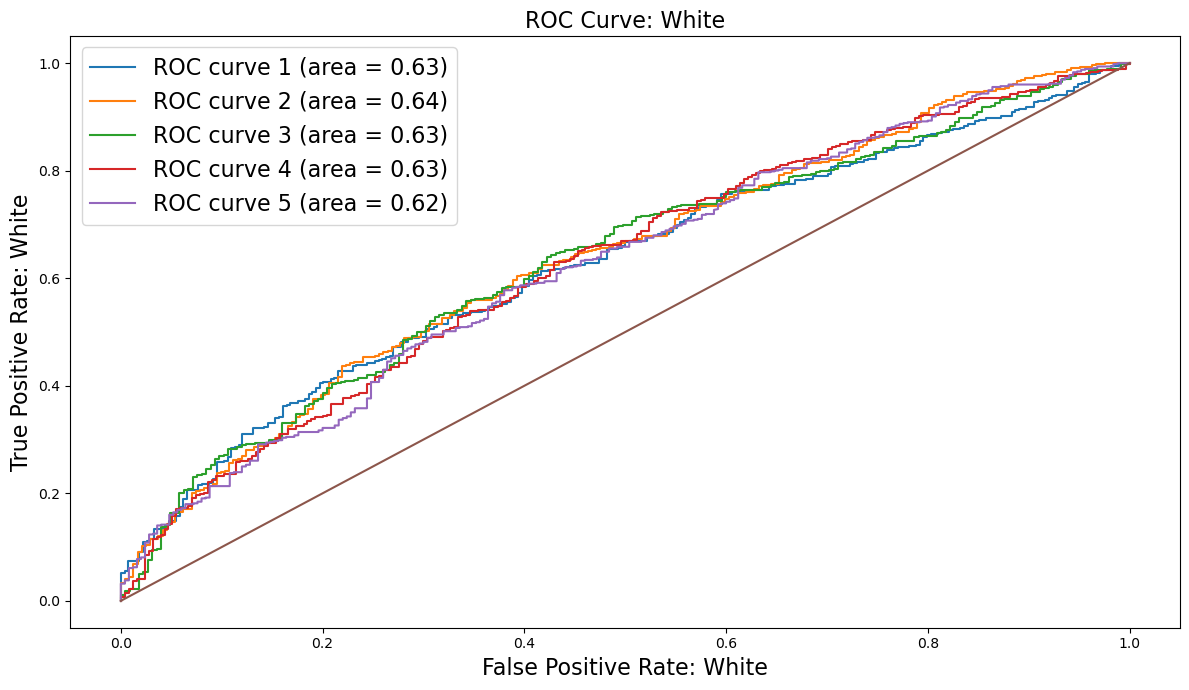

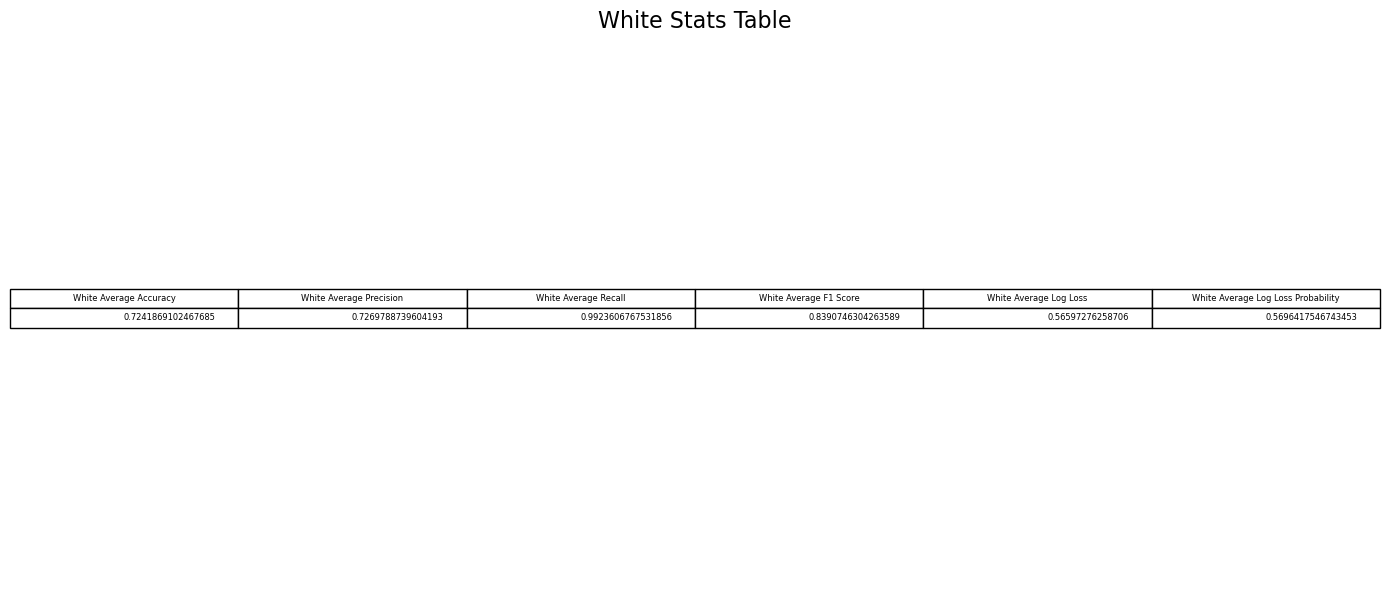

In [1341]:
# Since we have continuous numerical inputs, or features, in the form of: rating differentials, consecutive moves where a player follows an optimal book opening, and number of turns in the game 
# along with a transformation of the target, or wins versus draws and losses, to binary values, we ran a logistic regression model. 
# The logistic regression for both white and black utilized 5 folds, or subsets, with an 80% split of the samples into the training set and the remaining 20% of the data was held out for the test set. 
# We determined the true positive rate, or probability of detection, as a function of false positive rate, or probability of false alarm, and generated a Receiver Operating Characteristic (ROC) curves for all 5 folds. 
# Additionally, we generated the Area Under the Curve (AUC) for our ROC curves to determine the model's predictive accuracy and found that for all 5 folds, 
# for both black and white, the AUC was bound between 0.61 and 0.64, which is indicative of poor predictive accuracy for our model as 1.0 would be a perfect prediction. 
# We believe that the model's predictive accuracy would increase if additional quantitative features were provided in the dataset that factor into winning a chess game versus losing or drawing. 
# Some, but not all, of the excluded features are: hours of individual study/preparation, hours of analysis of the opponent's playstyle and openings selection, hours of sleep preceding the game, number of times the opponents have previously faced each other.
# Finally, perhaps introducing class-weights to punish the model for any wrong prediction of the class, 0 and 1 respectively, to overcome the imbalanced dataset that contains far more wins, or 1’s, than draws plus losses, or 0’s.
# Also, across all 5 folds, the average accuracy, precision, recall, F1 Score, log loss, and log loss probability were determined for white and black.
# Finally, an additional logistic regression model was ran to mainly analyze the p-values, or significance, of the features for both white and black games. 

def test_train_white(white_greater_100, path1='../images/roc_curve_white.png', path2='../images/stats_model_white.png', path3='../images/white_stats_table.png'):

    X = white_greater_100[['turns', 'opening_ply',
                           'Rating Differential White']].astype(int)
    y = white_greater_100['winner']

    random_seed = 8

    def cross_val_linear(X, y, k):

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_seed, stratify=y)

        log_reg = sm.Logit(y_train, X_train).fit()

        print(log_reg.summary())

        plt.rc('figure', figsize=(12, 7))

        plt.text(0.01, 0.05, str(log_reg.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
        plt.title('Logistic Regression Stats Model: White')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(path2)
        plt.clf()

        kf = KFold(k)

        kf.get_n_splits(X_train)

        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_score_list = []
        log_loss_list = []
    
        for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        
            X_train_kfold = X_train.iloc[train_index]
            y_train_kfold = y_train.iloc[train_index]
            X_test_kfold = X_train.iloc[test_index]
            y_test_kfold = y_train.iloc[test_index]

            log_model = LogisticRegression(random_state=random_seed).fit(X_train_kfold, y_train_kfold)
            y_pred = log_model.predict(X_test_kfold)
            y_prob = log_model.predict_proba(X_test_kfold)
            y_hat = log_model.decision_function(X_test_kfold)

            fpr, tpr, thresholds = metrics.roc_curve(y_test_kfold, y_hat)
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve ' + f'{i+1}' + ' (area = %0.2f)' % roc_auc)
        
            accuracy_list.append(metrics.accuracy_score(y_test_kfold, y_pred))
            precision_list.append(metrics.precision_score(y_test_kfold, y_pred))
            recall_list.append(metrics.recall_score(y_test_kfold,y_pred))
            f1_score_list.append(f1_score(y_test_kfold, y_pred, average='binary', zero_division='warn'))
            log_loss_list.append(log_loss(y_test_kfold, y_prob, normalize = True))
            log_loss_prob = (-1*np.log(log_loss_list))

        
        plt.plot([0,1], [0,1])
        plt.legend(fontsize = 16)
        plt.title('ROC Curve: White', fontsize = 16)
        plt.xlabel('False Positive Rate: White', fontsize = 16)
        plt.ylabel('True Positive Rate: White', fontsize = 16)
        plt.tight_layout()
        plt.savefig(path1)
        plt.show()

        plt.rcParams["figure.figsize"] = [14, 6]
        plt.rcParams["figure.autolayout"] = True
        fig, axs = plt.subplots(1, 1)
        data = [(np.mean(accuracy_list), np.mean(precision_list), np.mean(recall_list), np.mean(f1_score_list), np.mean(log_loss_list), np.mean(log_loss_prob))]
        columns = ("White Average Accuracy", "White Average Precision", "White Average Recall", "White Average F1 Score", "White Average Log Loss", "White Average Log Loss Probability")
        axs.set_title('White Stats Table', fontsize = 16)
        axs.axis('tight')
        axs.axis('off')
        white_stats_table = axs.table(cellText=data, colLabels=columns, loc='center')
        fontsize = 24
        white_stats_table.set_fontsize(fontsize)
        plt.tight_layout()
        plt.savefig(path3)
        plt.show()
        
    cross_val_linear(X, y, 5)
test_train_white(chess_differentials_white(chess_games))

# The average accuracy and average precision across all 5 folds for white are both respectable and nearly the same with the average accuracy being approximately 72.42% and the average precision being approximately 72.70%.
# Accuracy is a function of true positives, true negatives, false positives, or probability of false alarms, and false negatives, or probability of incorrectly identifying that an attribute is absent.
# We can ascertain that our logistic regression model is being reduced due to the reasonable amount of false positives that are present and is supported by our precision also being reduced due to the same false positive generation.
# Precision is a function of true positives, or probability of detection, and false positives, which is the probability of a false alarm. 
# We can ascertain that our logistic regression model has a reasonable amount of false positives, or incorrectly predicting the positive class of 1, when it should be predicting the negative class of 0, hence false positives are generated. 
# The average recall across all 5 folds for white was excellent with a result of approximately 99.24%.
# Recall is a function of true positives, or probability of detection, and false negatives, which is the probability of incorrectly identifying that an attribute is absent.
# We can ascertain that our logistic regression model has very few false negatives, which would be missing the ability to successsfully predict the correct, positive class of 1 and instead predicting a negative class of 0.
# The average F1 Score across all 5 folds for white was very good with a result of approximately 83.91%.
# The average F1 score is a function of the average precision and average recall. 
# The relatively good mean precision of 72.70% and stellar mean recall of 99.24% is yielding the great F1 score of approximately 83.91%. 
# The average log loss across all 5 folds for white was only average with a result of approximately 0.5660, where 0 is optimal. 
# The average log loss is effectively how close the model is to predicting the corresponding true values of 0 and 1, respectively. 
# The associated average probability of the log loss across all 5 folds for white was determined to be approximately 0.5696, which effectively denotes the probability of the logistic regression model predicting the proper class, 0 for draws & losses, and 1 for wins, respectively.
# The mediocre result for average log loss and average log loss probability could be due to an imbalanced dataset that truly contains significantly more wins, or binary values of 1, in comparison to draws & losses, or binary values of 0.

Optimization terminated successfully.
         Current function value: 0.598554
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 4184
Model:                          Logit   Df Residuals:                     4181
Method:                           MLE   Df Model:                            2
Date:                Tue, 07 Feb 2023   Pseudo R-squ.:                 0.02985
Time:                        13:43:46   Log-Likelihood:                -2504.3
converged:                       True   LL-Null:                       -2581.4
Covariance Type:            nonrobust   LLR p-value:                 3.391e-34
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
turns                        -0.0010      0.001     -1.212      0.225      -0.

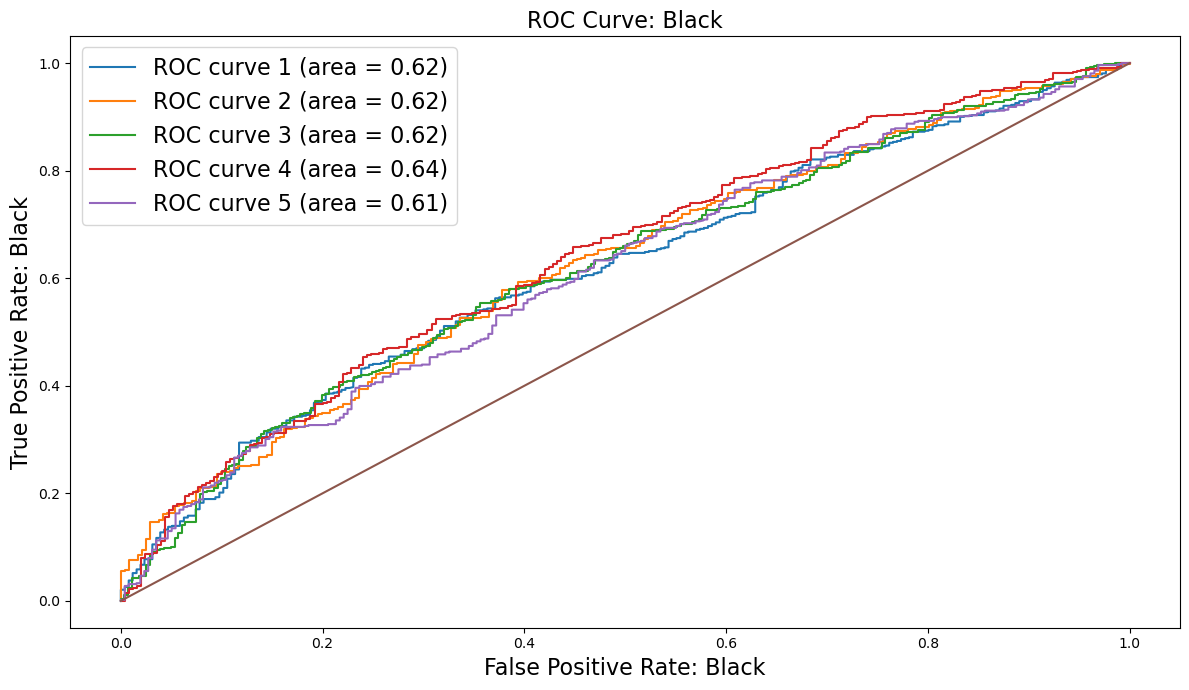

In [1283]:
# Defer to paragraph in top of previous cell for explanation.

def test_train_black(chess_df, path1='../images/roc_curve_black.png', path2='../images/stats_model_black.png'):
    chess_df = chess_df.copy()
    chess_df['Rating Differential Black'] = (chess_df['black_rating'] - chess_df['white_rating']).astype(int)
    black_greater_100 = chess_df[(chess_df['Rating Differential Black'] > 100)]

    def victory_status(s):
        if s == 'white' or s == 'draw' :
            return 0

        else:
            return 1
    
    black_greater_100['winner'] = black_greater_100['winner'].apply(victory_status).astype(int)


    X = black_greater_100[['turns', 'opening_ply', 'Rating Differential Black']].astype(int)
    y = black_greater_100['winner']

    random_seed = 8
   
    
    def cross_val_linear(X, y, k):    
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

        log_reg = sm.Logit(y_train, X_train).fit()

        print(log_reg.summary())

        plt.rc('figure', figsize=(12, 7))

        plt.text(0.01, 0.05, str(log_reg.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
        plt.title('Logistic Regression Stats Model: Black')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(path2)
        plt.clf()
    
        kf = KFold(k)
    
        kf.get_n_splits(X_train)

        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_score_list = []
        log_loss_list = []
    
        for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        
            X_train_kfold = X_train.iloc[train_index]
            y_train_kfold = y_train.iloc[train_index]
            X_test_kfold = X_train.iloc[test_index]
            y_test_kfold = y_train.iloc[test_index]

            log_model = LogisticRegression(random_state=random_seed).fit(X_train_kfold, y_train_kfold)
            y_pred = log_model.predict(X_test_kfold)
            y_prob = log_model.predict_proba(X_test_kfold)
            y_hat = log_model.decision_function(X_test_kfold)

            fpr, tpr, thresholds = metrics.roc_curve(y_test_kfold, y_hat)
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve ' + f'{i+1}' + ' (area = %0.2f)' % roc_auc)
        
            accuracy_list.append(metrics.accuracy_score(y_test_kfold, y_pred))
            precision_list.append(metrics.precision_score(y_test_kfold, y_pred))
            recall_list.append(metrics.recall_score(y_test_kfold,y_pred))
            f1_score_list.append(f1_score(y_test_kfold, y_pred, average='binary', zero_division='warn'))
            log_loss_list.append(log_loss(y_test_kfold, y_prob, normalize = True))
            log_loss_prob = (-1*np.log(log_loss_list))

        black_stats = [['Black Average Accuracy', 'Black Average Precision', 'Black Average Recall', 'Black Average F1 Score', 'Black Average Log Loss', 'Black Average Log Loss Probability'], [np.mean(accuracy_list), np.mean(precision_list), np.mean(recall_list), np.mean(f1_score_list), np.mean(log_loss_list), np.mean(log_loss_prob)]]
        black_stats_table = ((tabulate(black_stats, headers='firstrow', tablefmt='grid')))
        textFilePath = "../images/black_stats_table.txt"
        with open(textFilePath, 'w') as f:
            f.write(black_stats_table)

        plt.plot([0,1], [0,1])
        plt.legend(fontsize = 16)
        plt.title('ROC Curve: Black', fontsize = 16)
        plt.xlabel('False Positive Rate: Black', fontsize = 16)
        plt.ylabel('True Positive Rate: Black', fontsize = 16)
        plt.tight_layout()
        plt.savefig(path1)
        return print({'Mean Accuracy List [Black]': np.mean(accuracy_list), 'Mean Precision List [Black]': np.mean(precision_list), 'Mean Recall List [Black]': np.mean(recall_list), 'Mean F1 Score [Black]': np.mean(f1_score_list), 'Mean Log Loss [Black]': np.mean(log_loss_list), 'Mean Log Loss Probability [Black]': np.mean(log_loss_prob)})
        


    cross_val_linear(X, y, 5)
test_train_black(chess_games)

# The average accuracy and average precision across all 5 folds for black are both respectable and nearly the same with the average accuracy being approximately 69.38% and the average precision being approximately 69.39%.
# Accuracy is a function of true positives, true negatives, false positives, or probability of false alarms, and false negatives, or probability of incorrectly identifying that an attribute is absent.
# We can ascertain that our logistic regression model is being reduced due to the reasonable amount of false positives that are present and is supported by our precision also being reduced due to the same false positive generation.
# Precision is a function of true positives, or probability of detection, and false positives, which is the probability of a false alarm. 
# We can ascertain that our logistic regression model has a reasonable amount of false positives, or incorrectly predicting the positive class of 1, when it should be predicting the negative class of 0, hence false positives are generated. 
# The average recall across all 5 folds for black was excellent with a result of approximately 99.83%.
# Recall is a function of true positives, or probability of detection, and false negatives, which is the probability of incorrectly identifying that an attribute is absent.
# We can ascertain that our logistic regression model has very few false negatives, which would be missing the ability to successsfully predict the correct, positive class of 1 and instead predicting a negative class of 0.
# The average F1 Score across all 5 folds for black was very good with a result of approximately 81.86%.
# The average F1 score is a function of the average precision and average recall. 
# The relatively good mean precision of 69.39% and stellar mean recall of 99.83% is yielding the great F1 score of approximately 81.86%. 
# The average log loss across all 5 folds for black was only average with a result of approximately 0.5969, where 0 is optimal. 
# The associated average probability of the log loss across all 5 folds for black was determined to be approximately 0.5162, which effectively denotes the probability of the logistic regression model predicting the proper class, 0 for draws & losses, and 1 for wins, respectively.
# The mediocre result for average log loss and average log loss probability could be due to an imbalanced dataset that truly contains significantly more wins, or binary values of 1, in comparison to draws & losses, or binary values of 0.

In [1284]:
# Conclusion
# When comparing filtered games where white is the superior opponent with black being the superior opponent, the total games in each respective database very similar with comparable wins versus draws and losses. 
# When running one version of a logistic regression model for both white and black games, we see very similar average metrics for the accuracy, precision, recall, F1 score, log loss, and log loss probability. 
# However, when utilizing a different logistic regression statistical model, a worthwhile not is looking at the respective inputs, or features, for our white and black chess games, respectively. 
# The three features utilized for both black and white games were rating differential, number of turns in the game, and opening play, which is the consecutive moves from the initiation of the game that opponents stick to an optimal, book opening. 
# In general, typically skilled players, even with reasonable rating differentials, will have games with a substantial amount of moves because they avoid suboptimal moves and outright blunders.
# More specifically, with the white games, our three features all had p-values of 0.000, which are significant since they are less than 0.05, and thus are a good choice to be incorporated into predicting our target, or binary output of wins versus draws and losses.
# Regarding the black games, the rating differential feature was determined to be significant at 0.000, but interestingly enough the number of terms and opening play were didn't yeild significant p-values, or greater than 0.05, at 0.225 and 0.372, respectively.
# There has been extensive, cumulative analysis on chess throughout the years to determine that white has an innate advantage simply by being the first player to make a move.
# The respective difference in significances of our features between white and black games might indicate the fact that due to the inherent disadvantage of black being the responsive player, there is no significance on the number of moves and sticking to an optimal book opening. 
# Essentially, the disadvantage of moving second might trump the ability to follow optimal book openings and play in technically sound games that contain a large number of moves.